In [ ]:
import json
import yaml
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML

project_root = "/home/ubuntu/VOCAL-UDF/"

config = yaml.safe_load(open(os.path.join(project_root, "configs", "config.yaml"), "r"))

import re
from datetime import datetime
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [5]:
def prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name):
    def _compute_test_f1_score_helper(lines):
        total_time = 0
        i = 0
        while i < len(lines):
            # if "UDF selection finished" in lines[i]:
            #     i += 1
            #     break
            if "compute test F1 score" in lines[i]:
                datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[i]).group()

                # Convert the extracted string to a datetime object
                dt_format = "%Y-%m-%d %H:%M:%S,%f"
                start_datetime = datetime.strptime(datetime_str, dt_format)
                for j in range(i+1, len(lines)):
                    pattern = r"positive: (-?\d+), negative: (-?\d+)"
                    match = re.search(pattern, lines[j])
                    if match:
                        if "UDFCandidate" in lines[j+1]:
                            datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[j]).group()
                            end_datetime = datetime.strptime(datetime_str, dt_format)
                            end_index = j + 1
                        else:
                            # data.append((dataset, query_class_name, question_id, run_id, "udf selection", "computing test score", (end_datetime - start_datetime).total_seconds()))
                            total_time += (end_datetime - start_datetime).total_seconds()
                            end_index = j
                            break
                i = end_index
            i += 1
        return total_time

    data = [] # (dataset, num_missing_udfs, query_class_name, question_id, run_id, type, time)
    udf_generation_data = [] # (dataset, num_missing_udfs, query_class_name, question_id, run_id, type, time)
    cost_data = [] # (dataset, num_missing_udfs, query_class_name, question_id, run_id, type, cost)
    for num_missing_udfs in num_missing_udfs_list:
        for query_class_name in query_class_names:
            for run_id in run_ids:
                for question_id in question_ids:
                    with open(os.path.join(config['output_dir'], "udf_generation", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.json"), "r") as f:
                        output_dict = json.load(f)
                    num_generated_udfs = len(output_dict["materialized_df_names"]) + len(output_dict["on_the_fly_udf_names"])

                    try:
                        with open(os.path.join(config['log_dir'], "query_execution", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                            for line in lines:
                                if "Test data initialization time:" in line:
                                    runtime = float(line.split("Test data initialization time:")[-1].strip())
                                    data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, "resource_init", runtime])
                                elif "Query execution time:" in line:
                                    runtime = float(line.split("Query execution time:")[-1].strip())
                                    data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, "query_execution", runtime])
                            # # print("query execution")
                            # datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[0]).group()

                            # # Convert the extracted string to a datetime object
                            # dt_format = "%Y-%m-%d %H:%M:%S,%f"
                            # start_datetime = datetime.strptime(datetime_str, dt_format)
                            # for line in lines:
                            #     if "Peak memory usuage" in line:
                            #         datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", line).group()
                            #         end_datetime = datetime.strptime(datetime_str, dt_format)
                            #         data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "query_execution", (end_datetime - start_datetime).total_seconds()])
                            #         break
                    except Exception as e:
                        print(e)
                        continue


                    try:
                        print(f"num_missing_udfs={num_missing_udfs}, query_class_name={query_class_name}, question_id={question_id}, run_id={run_id}")
                        with open(os.path.join(config['log_dir'], "udf_generation", dataset, query_class_name, f"num_missing_udfs={num_missing_udfs}", vocal_udf_config_name, f"qid={question_id}-run={run_id}.log"), "r") as f:
                            lines = f.readlines()
                        # Total generation time
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[0]).group()
                        dt_format = "%Y-%m-%d %H:%M:%S,%f"
                        start_datetime = datetime.strptime(datetime_str, dt_format)
                        datetime_str = re.search(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}", lines[-1]).group()
                        end_datetime = datetime.strptime(datetime_str, dt_format)
                        total_generation_time = (end_datetime - start_datetime).total_seconds()
                        # data.append([dataset, num_missing_udfs, query_class_name, question_id, run_id, "total_generation", (end_datetime - start_datetime).total_seconds()])

                        udf_selection_time = 0
                        udf_generation_other_time = 0
                        for line in lines[::-1]:
                            if "Total execution time:" in line:
                                match = re.search(r"Total execution time: defaultdict\(<class 'float'>, ({.*})\)", line)
                                dict_str = match.group(1)
                                execution_time = eval(dict_str)
                                for type, time in execution_time.items():
                                    if type == "udf_generation":
                                        udf_generation_other_time += time

                                    if type == "udf_selection":
                                        udf_selection_time = time
                                    else:
                                        data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, type, time])
                            elif "UDF generation execution time:" in line:
                                match = re.search(r"UDF generation execution time: defaultdict\(<class 'float'>, ({.*})\)", line)
                                dict_str = match.group(1)
                                execution_time = eval(dict_str)
                                for type, time in execution_time.items():
                                    udf_generation_data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, type, time])
                                    udf_generation_other_time -= time
                            elif "Cost estimation:" in line:
                                match = re.search(r"Cost estimation: defaultdict\(<class 'float'>, ({.*})\)", line)
                                dict_str = match.group(1)
                                cost_dict = eval(dict_str)
                                for type, cost in cost_dict.items():
                                    cost_data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, type, cost])
                        udf_generation_data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, "other", udf_generation_other_time])

                        # Remove the time spent on computing test F1 score from the time spent on UDF selection
                        test_f1_score_time = _compute_test_f1_score_helper(lines)
                        udf_selection_time -= test_f1_score_time
                        total_generation_time -= test_f1_score_time
                        data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, "udf_selection", udf_selection_time])
                        data.append([dataset, num_generated_udfs, query_class_name, question_id, run_id, "total_generation", total_generation_time])
                    except Exception as e:
                        print(e)
                        continue
    return data, udf_generation_data, cost_data

In [ ]:
data = []
udf_generation_data = []
cost_data = []

# Clevrer
dataset = "clevrer"
query_class_names = [
    "3_new_udfs_labels",
]
question_ids = list(range(30))
run_ids = list(range(3))
num_missing_udfs_list = list(range(4))
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=True-pretrained_models=False-ntrain_distill=100-nselection_samples=500-selection=both-budget=20-llm_method=gpt"

res = prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name)
data += res[0]
udf_generation_data += res[1]
cost_data += res[2]

# CityFlow
dataset = "cityflow"
query_class_names = [
    "unavailable_pred=1-unavailable_attr_pred=1-npred=1-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737",
    "unavailable_pred=1-unavailable_attr_pred=1-npred=2-nattr_pred=2-nvars=3-depth=3-max_duration=15-min_npos=74-max_npos=737"
]
question_ids = list(range(15))
run_ids = list(range(3))
num_missing_udfs_list = list(range(3))
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-budget=50-llm_method=gpt"

res = prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name)
data += res[0]
udf_generation_data += res[1]
cost_data += res[2]

# Charades
dataset = "charades"
query_class_names = [
    "unavailable=2-npred=4-nobj_pred=1-nvars=3-depth=2",
    "unavailable=2-npred=4-nobj_pred=1-nvars=2-depth=2",
    "unavailable=2-npred=3-nobj_pred=1-nvars=2-depth=2"
]
question_ids = list(range(10))
run_ids = list(range(3))
num_missing_udfs_list = list(range(3))
vocal_udf_config_name = "ninterp=10-nparams=5-kwargs=True-pixels=False-pretrained_models=False-ntrain_distill=500-nselection_samples=500-selection=both-budget=50-llm_method=gpt"

res = prepare_data(dataset, query_class_names, num_missing_udfs_list, question_ids, run_ids, vocal_udf_config_name)
data += res[0]
udf_generation_data += res[1]
cost_data += res[2]

total_time_df = pd.DataFrame(data, columns=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "type", "time"])
udf_generation_time_df = pd.DataFrame(udf_generation_data, columns=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "type", "time"])
cost_df = pd.DataFrame(cost_data, columns=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "type", "cost"])

num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=0, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=1, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=2, run_id=0


num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=3, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=4, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=5, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=6, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=7, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=8, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=9, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=10, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=11, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=12, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=13, run_id=0
num_missing_udfs=0, query_class_name=3_new_udfs_labels, question_id=14, run_id=0
num_missing_udfs=0, query_class_nam

In [7]:
# count number of rows with dataset == "clevrer" and num_missing_udfs == 4
print("dataset == 'clevrer' and num_missing_udfs >= 4: ", total_time_df[(total_time_df["dataset"] == "clevrer") & (total_time_df["num_missing_udfs"] >= 4)][["query_class_name", "question_id", "run_id"]].drop_duplicates().shape[0])
print("dataset == 'cityflow' and num_missing_udfs >= 3: ", total_time_df[(total_time_df["dataset"] == "cityflow") & (total_time_df["num_missing_udfs"] >= 3)][["query_class_name", "question_id", "run_id"]].drop_duplicates().shape[0])
print("dataset == 'charades' and num_missing_udfs >= 3: ", total_time_df[(total_time_df["dataset"] == "charades") & (total_time_df["num_missing_udfs"] >= 3)][["query_class_name", "question_id", "run_id"]].drop_duplicates().shape[0])
print(udf_generation_time_df.to_string())

dataset == 'clevrer' and num_missing_udfs >= 4:  1
dataset == 'cityflow' and num_missing_udfs >= 3:  1
dataset == 'charades' and num_missing_udfs >= 3:  0
       dataset  num_missing_udfs                                                                                                          query_class_name  question_id  run_id                                type         time
0      clevrer                 0                                                                                                         3_new_udfs_labels            0       0                               other     0.000000
1      clevrer                 0                                                                                                         3_new_udfs_labels            1       0                               other     0.000000
2      clevrer                 0                                                                                                         3_new_udfs_labels            2   

In [8]:
# Sanity check
# def sanity_check(df):
#     df_total_generation = df[df["type"] == "total_generation"]
#     df_total_generation = df_total_generation[["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id", "time"]]
#     df_total_generation = df_total_generation.rename(columns={"time": "total_generation_time"})

#     df_filtered = df[(df["type"] != "total_generation") & (df["type"] != "query_execution")]
#     # group by query_class_name, question_id, run_id, and then sum the time column
#     df_filtered = df_filtered.groupby(["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id"]).agg({"time": "sum"}).reset_index()
#     df_filtered = df_filtered.rename(columns={"time": "sum_time"})
#     df_filtered = df_filtered.merge(df_total_generation, on=["dataset", "num_missing_udfs", "query_class_name", "question_id", "run_id"], how="left")
#     # compute percentage difference as a new column
#     df_filtered["percentage"] = (df_filtered["total_generation_time"] - df_filtered["sum_time"]) / df_filtered["total_generation_time"] * 100

#     print(df_filtered.to_string())

# sanity_check(total_time_df)

In [9]:
# print(df.to_string())

In [10]:
def plot_total_time_breakdown(ax, dataset, dataset_title, target_df, title_name, x_label):
    df_plot = target_df[(target_df["type"] != "total_generation") & (target_df["type"] != "resource_init")]
    df_plot = df_plot[df_plot["dataset"] == dataset]
    if dataset == "clevrer":
        df_plot = df_plot[df_plot["num_missing_udfs"] < 4]
    elif dataset == "cityflow":
        df_plot = df_plot[df_plot["num_missing_udfs"] < 3]
    df_plot = df_plot.drop(columns=["dataset"])
    df_plot = df_plot.groupby(["num_missing_udfs", "query_class_name", "question_id", "run_id", "type"])\
                     .agg({x_label: "sum"}).reset_index()

    # Convert time to minutes
    if x_label == "time":
        df_plot.loc[:, x_label] = df_plot[x_label] / 60

    cmap = plt.get_cmap('tab20')
    # hatch_patterns = ['...', '///', '\\\\\\', 'xxx', '***', '+++', '|||', '---', 'ooo']

    # Plotting each type as a stack
    if title_name == "total_time":
        types = ["query_parsing", "udf_proposal", "udf_generation", "udf_selection", "query_execution"]
        rename_dict = {
            # "resource_init": "data preparation",
            "query_parsing": "query parsing",
            "udf_proposal": "UDF proposal",
            "udf_generation": "UDF generation",
            "udf_selection": "UDF selection",
            "query_execution": "query execution"
        }
    elif title_name == "udf_generation_time":
        types = ["program_generation", "model_distillation_init", "model_distillation_data_loading",
                 "model_distillation_data_labeling", "model_distillation_model_training",
                 "model_distillation_active_learning", "other"]
        rename_dict = {
            "program_generation": "program",
            "model_distillation_init": "model: init",
            "model_distillation_data_loading": "model: data loading",
            "model_distillation_data_labeling": "model: data labeling",
            "model_distillation_model_training": "model: model training",
            "model_distillation_active_learning": "model: active learning",
            "other": "other"
        }
    elif title_name == "cost":
        types = ["query_parser", "propose_udfs", "generate_program", "model_udf_data_labeling",
                 "verify_syntax_correctness"]
        rename_dict = {
            "query_parser": "query parsing",
            "propose_udfs": "UDF proposal",
            "generate_program": "program generation",
            "model_udf_data_labeling": "model data labeling",
            "verify_syntax_correctness": "program syntax verification"
        }

    color_map = {
        "query_parsing": cmap(0),
        "udf_proposal": cmap(1),
        "udf_generation": cmap(2),
        "udf_selection": cmap(3),
        "query_execution": cmap(4),
        "program_generation": cmap(5),
        "model_distillation_init": cmap(6),
        "model_distillation_data_loading": cmap(7),
        "model_distillation_data_labeling": cmap(8),
        "model_distillation_model_training": cmap(9),
        "model_distillation_active_learning": cmap(10),
        "other": cmap(11),
        "query_parser": cmap(0),
        "propose_udfs": cmap(1),
        "generate_program": cmap(5),
        "model_udf_data_labeling": cmap(8),
        "verify_syntax_correctness": cmap(12)
    }

    hatch_map = {
        "query_parsing": '//',
        "udf_proposal": '\\\\',
        "udf_generation": '||',
        "udf_selection": '--',
        "query_execution": '++',
        "program_generation": '..',
        "model_distillation_init": 'xx',
        "model_distillation_data_loading": 'oo',
        "model_distillation_data_labeling": '**',
        "model_distillation_model_training": 'OO',
        "model_distillation_active_learning": 'XX',
        "other": '/o',
        "query_parser": '//',
        "propose_udfs": '\\\\',
        "generate_program": '..',
        "model_udf_data_labeling": '**',
        "verify_syntax_correctness": '\\|'
    }
    bottom = pd.Series([0.0] * len(df_plot['num_missing_udfs'].unique()),
                       index=df_plot['num_missing_udfs'].unique())
    all_num_missing_udfs = df_plot['num_missing_udfs'].unique()
    y_positions = [0, 0.5, 1, 1.5, 2, 2.5][:all_num_missing_udfs.shape[0]]

    # Plotting each subtype on top of each other
    for i, type in enumerate(types):
        subset = df_plot[df_plot['type'] == type].groupby('num_missing_udfs')[x_label].sum()\
                 .reindex(all_num_missing_udfs, fill_value=0) / \
                 df_plot.groupby('num_missing_udfs').apply(lambda x: x[['query_class_name', 'question_id', 'run_id']]\
                 .drop_duplicates().shape[0], include_groups=False)
        ax.barh(y_positions, subset.values, label=rename_dict[type],
                left=bottom[subset.index], height=0.3, color=color_map[type],
                hatch=hatch_map[type], tick_label=subset.index)
        bottom[subset.index] += subset.values
    print(bottom)

    # Setting labels and title
    if x_label == "time":
        ax.set_xlabel('Time (mins)')
    else:
        ax.set_xlabel('Cost ($ USD)')
    ax.set_ylabel('# generated UDFs')
    ax.set_title(dataset_title, fontsize=10)

0     1.611757
1    11.516075
2    19.878869
3    27.918535
dtype: float64
0     0.090000
1    10.761318
2    18.580977
dtype: float64
0     0.113505
1    14.373752
2    21.968038
dtype: float64


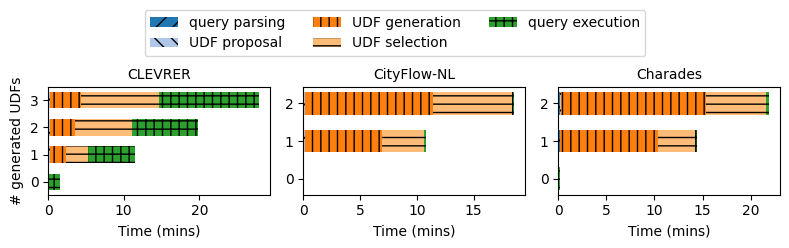

In [11]:
# Main code to create subplots
datasets = ["clevrer", "cityflow", "charades"]
dataset_titles = ["CLEVRER", "CityFlow-NL", "Charades"]
fig, axes = plt.subplots(1, 3, figsize=(8, 2))

for ax, dataset, dataset_title in zip(axes, datasets, dataset_titles):
    plot_total_time_breakdown(ax, dataset, dataset_title, total_time_df, "total_time", "time")

# Only set the y-axis label on the left-most subplot
for i in range(1, len(axes)):
    axes[i].set_ylabel("")

# Adjust layout and add the main title\
# fig.subplots_adjust(left=0.15)  # Adjust left to make space for the main title
# fig.text(-0.01, 0.5, '(a) Total Time', va='center', ha='left', fontsize=12, fontweight='bold')

# Create the legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, prop={"size": 10}, fancybox=True, shadow=False) # On the top

# Save and show the combined figure
fig.tight_layout()
fig.savefig("figures/total_time.pdf", bbox_inches='tight')
plt.show()

0    1.339430e-08
1    2.139759e+00
2    3.276467e+00
3    4.140198e+00
dtype: float64
0     0.000000
1     6.747339
2    11.274831
dtype: float64
0    8.856257e-08
1    1.016302e+01
2    1.517381e+01
dtype: float64


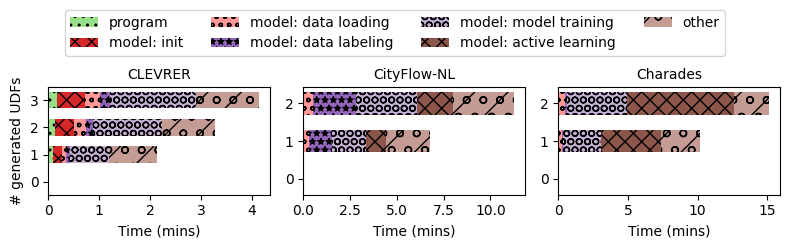

In [12]:
# Main code to create subplots
datasets = ["clevrer", "cityflow", "charades"]
dataset_titles = ["CLEVRER", "CityFlow-NL", "Charades"]
fig, axes = plt.subplots(1, 3, figsize=(8, 2))

for ax, dataset, dataset_title in zip(axes, datasets, dataset_titles):
    plot_total_time_breakdown(ax, dataset, dataset_title, udf_generation_time_df, "udf_generation_time", "time")

# Only set the y-axis label on the left-most subplot
for i in range(1, len(axes)):
    axes[i].set_ylabel("")

# Adjust layout and add the main title

# fig.subplots_adjust(left=0.15)  # Adjust left to make space for the main title
# fig.text(-0.01, 0.5, '(b) UDF\nGeneration\nTime', va='center', ha='left', fontsize=12, fontweight='bold')

# Create the legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=4, prop={"size": 10}, fancybox=True, shadow=False) # On the top

# Save and show the combined figure
fig.tight_layout()
fig.savefig("figures/udf_generation_time.pdf", bbox_inches='tight')
plt.show()

0    0.010161
1    0.139973
2    0.287013
3    0.392164
dtype: float64
0    0.004284
1    0.448371
2    0.906166
dtype: float64
0    0.008636
1    0.581129
2    0.998467
dtype: float64


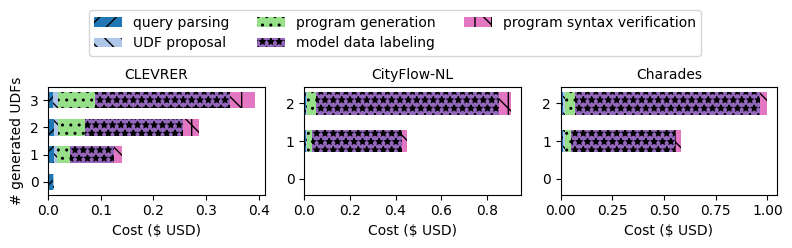

In [13]:
# Main code to create subplots
datasets = ["clevrer", "cityflow", "charades"]
dataset_titles = ["CLEVRER", "CityFlow-NL", "Charades"]
fig, axes = plt.subplots(1, 3, figsize=(8, 2))

for ax, dataset, dataset_title in zip(axes, datasets, dataset_titles):
    plot_total_time_breakdown(ax, dataset, dataset_title, cost_df, "cost", "cost")

# Only set the y-axis label on the left-most subplot
for i in range(1, len(axes)):
    axes[i].set_ylabel("")

# Adjust layout and add the main title
# fig.subplots_adjust(left=0.15)  # Adjust left to make space for the main title
# fig.text(-0.01, 0.5, '(c) Monetary\nCost', va='center', ha='left', fontsize=12, fontweight='bold')

# Create the legend
handles, labels = axes[0].get_legend_handles_labels()
# figLegend = plt.figure(figsize=(8, 1))
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, prop={"size": 10}, fancybox=True, shadow=False) # On the top
# figLegend.savefig('figures/cost_legend.pdf', bbox_inches='tight')
fig.tight_layout()

# Save and show the combined figure
fig.savefig("figures/cost.pdf", bbox_inches='tight')
plt.show()